In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [68]:
CSV_PATH = "data_penjualan.csv"   
DELIMITER = ";"                  
SAVE_CLEANED_CSV = True          
CLEANED_CSV_PATH = "data_penjualan_clean.csv"


In [69]:
df = pd.read_csv(CSV_PATH, delimiter=DELIMITER)

print("\n[Data Penjualan Sebelum Cleaning]")
print(df.head())



[Data Penjualan Sebelum Cleaning]
      Tanggal      Jenis Produk  Jumlah Order  Harga    Total
0  05/08/2022        Foodpak260          1000   1800  1800000
1  05/08/2022   FoodpakMatte245          1000   1900  1900000
2  05/08/2022  CraftLaminasi290          5000    750  3750000
3  05/08/2022  CraftLaminasi290          1000   1200  1200000
4  07/08/2022        Dupleks310          1000   1550  1550000


In [70]:
# 2. Data Cleaning
if "Tanggal" in df.columns:
    df["Tanggal"] = pd.to_datetime(df["Tanggal"], format="%d/%m/%Y", errors="coerce")
if "Jenis Produk" in df.columns:
    df["Jenis Produk"] = (
        df["Jenis Produk"]
        .astype(str)
        .str.strip()
        .str.title()
    )
if "Tanggal" in df.columns:
    before_drop = df.shape[0]
    df = df.dropna(subset=["Tanggal"]).reset_index(drop=True)
    after_drop = df.shape[0]
    print(f"\n[Cleaning] Baris NaT pada 'Tanggal' dihapus: {before_drop - after_drop} baris")

dup = df.duplicated().sum()
print(f"[Cleaning] Jumlah baris duplikat terdeteksi: {dup}")
df = df.drop_duplicates().reset_index(drop=True)

print("\n[Missing Values per Kolom]")
print(df.isnull().sum())


[Cleaning] Baris NaT pada 'Tanggal' dihapus: 0 baris
[Cleaning] Jumlah baris duplikat terdeteksi: 40

[Missing Values per Kolom]
Tanggal         0
Jenis Produk    0
Jumlah Order    0
Harga           0
Total           0
dtype: int64


In [ ]:
# 3. Menangani Outlier
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

mask = pd.Series(True, index=df.index)
for col in numeric_cols:
    if df[col].notna().sum() < 5: 
        continue
    lower, upper = iqr_bounds(df[col])
    mask &= (df[col] >= lower) & (df[col] <= upper)

before = df.shape[0]
df = df[mask].reset_index(drop=True)
after = df.shape[0]

print(f"Jumlah data sebelum: {before}")
print(f"Jumlah data sesudah: {after}")
print(f"Jumlah data outlier dihapus: {before - after}")

Jumlah data sebelum: 1036
Jumlah data sesudah: 897
Jumlah data outlier dihapus: 139


In [72]:
# 3. Data Standardization (untuk kolom numerik)
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df_std = df.copy()
for c in numeric_cols:
    mu = df[c].mean()
    sigma = df[c].std(ddof=1)
    if sigma and sigma != 0:
        df_std[c] = (df[c] - mu) / sigma
    else:
        df_std[c] = 0.0

if SAVE_CLEANED_CSV:
    df.to_csv(CLEANED_CSV_PATH, index=False)
    print(f"\n[Saved] Dataset cleaned tersimpan ke: {CLEANED_CSV_PATH}")


[Saved] Dataset cleaned tersimpan ke: data_penjualan_clean.csv


In [ ]:
# Menampilkan statistik deskriptif
stats = df[numeric_cols].describe(percentiles=[0.25, 0.5, 0.75]).T
stats = stats.rename(columns={"25%": "Q1", "50%": "Q2", "75%": "Q3"})

print("\n[STATISTIK DESKRIPTIF - NUMERIK]")
print(stats[["count", "mean", "std", "min", "Q1", "Q2", "Q3", "max"]])

print("\n[10 RECORD PERTAMA - ATRIBUT NUMERIK]")
print(df[numeric_cols].head(10))


[STATISTIK DESKRIPTIF - NUMERIK]
              count          mean           std      min         Q1  \
Jumlah Order  897.0  1.414486e+03  7.006939e+02    100.0     1000.0   
Harga         897.0  1.446047e+03  6.048334e+02    100.0      975.0   
Total         897.0  1.932677e+06  1.016027e+06  15376.0  1250000.0   

                     Q2         Q3        max  
Jumlah Order     1000.0     2000.0     3500.0  
Harga            1500.0     1800.0     3050.0  
Total         1750000.0  2500000.0  5400000.0  

[10 RECORD PERTAMA - ATRIBUT NUMERIK]
   Jumlah Order  Harga    Total
0          1000   1800  1800000
1          1000   1900  1900000
2          1000   1200  1200000
3          1000   1550  1550000
4           500   1900   950000
5          1000   1700  1700000
6          1000   1000  1000000
7          1500    850  1275000
8           500   1800   900000
9           500   1600   800000


In [74]:
# ubah kolom tanggal ke tipe datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

# buat fitur turunan waktu
df['Tahun'] = df['Tanggal'].dt.year
df['Bulan'] = df['Tanggal'].dt.month
df['Hari'] = df['Tanggal'].dt.day
df['Hari_ke'] = df['Tanggal'].dt.dayofyear
df['Hari_dalam_minggu'] = df['Tanggal'].dt.dayofweek  # 0 = Senin

# hapus kolom tanggal asli agar tidak di-one-hot
df.drop(columns=['Tanggal'], inplace=True)

df_encoded = df.copy()

num_cols = df_encoded.select_dtypes(include=['number']).columns.tolist()
cat_cols = df_encoded.select_dtypes(exclude=['number']).columns.tolist()

print("Kolom numerik :", num_cols)
print("Kolom kategorikal :", cat_cols)

if len(cat_cols) > 0:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_array = ohe.fit_transform(df_encoded[cat_cols])
    encoded_cols = ohe.get_feature_names_out(cat_cols)

    encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df_encoded.index)
    df_encoded = pd.concat([df_encoded[num_cols], encoded_df], axis=1)

print("\n=== Data Setelah Encoding (dengan fitur waktu) ===")
print(df_encoded.head())
print(f"\nJumlah kolom sesudah encoding : {len(df_encoded.columns)}")

Kolom numerik : ['Jumlah Order', 'Harga', 'Total', 'Tahun', 'Bulan', 'Hari', 'Hari_ke', 'Hari_dalam_minggu']
Kolom kategorikal : ['Jenis Produk']

=== Data Setelah Encoding (dengan fitur waktu) ===
   Jumlah Order  Harga    Total  Tahun  Bulan  Hari  Hari_ke  \
0          1000   1800  1800000   2022      8     5      217   
1          1000   1900  1900000   2022      8     5      217   
2          1000   1200  1200000   2022      8     5      217   
3          1000   1550  1550000   2022      8     7      219   
4           500   1900   950000   2022      8     8      220   

   Hari_dalam_minggu  Jenis Produk_245  Jenis Produk_260Glossy  ...  \
0                  4               0.0                     0.0  ...   
1                  4               0.0                     0.0  ...   
2                  4               0.0                     0.0  ...   
3                  6               0.0                     0.0  ...   
4                  0               0.0                     0.0

In [ ]:
# 5. Feature Engineering
source_df = df_encoded.copy() 


required_numeric = ["Jumlah Order", "Harga", "Total", "Bulan", "Hari_dalam_minggu"]
missing = [c for c in required_numeric if c not in source_df.columns]
if missing:
    raise KeyError(f"Kolom wajib berikut belum ada di DataFrame: {missing}\n"
                   f"Pastikan langkah encoding & ekstraksi tanggal sudah dijalankan.")

df_fe = source_df.copy()
# Fitur 1: Harga per Item
df_fe["Harga_per_Item"] = df_fe["Total"] / df_fe["Jumlah Order"].replace(0, np.nan)
df_fe["Harga_per_Item"] = df_fe["Harga_per_Item"].replace([np.inf, -np.inf], np.nan).fillna(0)
# Fitur 2: Akhir Pekan (1 jika Sabtu/Minggu, 0 jika Senin-Jumat)
df_fe["Akhir_Pekan"] = (df_fe["Hari_dalam_minggu"] >= 5).astype(int)
# Fitur 3: Kuartal (1-4)
df_fe["Kuartal"] = np.ceil(df_fe["Bulan"] / 3).astype(int)

new_cols = ["Harga_per_Item", "Akhir_Pekan", "Kuartal"] 
preview_cols = [c for c in ["Jumlah Order", "Harga", "Total", "Bulan", "Hari_dalam_minggu"] if c in df_fe.columns] + new_cols

print("=== Contoh 10 baris setelah Feature Engineering ===")
display(df_fe[preview_cols].head(10))

print(f"\nJumlah kolom setelah feature engineering: {len(df_fe.columns)}")
print(f"Kolom baru yang ditambahkan: {new_cols}")


=== Contoh 10 baris setelah Feature Engineering ===


,Jumlah Order,Harga,Total,Bulan,Hari_dalam_minggu,Harga_per_Item,Akhir_Pekan,Kuartal
0,1000,1800,1800000,8,4,1800.0,0,3
1,1000,1900,1900000,8,4,1900.0,0,3
2,1000,1200,1200000,8,4,1200.0,0,3
3,1000,1550,1550000,8,6,1550.0,1,3
4,500,1900,950000,8,0,1900.0,0,3
5,1000,1700,1700000,8,0,1700.0,0,3
6,1000,1000,1000000,8,1,1000.0,0,3
7,1500,850,1275000,8,1,850.0,0,3
8,500,1800,900000,8,1,1800.0,0,3
9,500,1600,800000,8,2,1600.0,0,3



Jumlah kolom setelah feature engineering: 93
Kolom baru yang ditambahkan: ['Harga_per_Item', 'Akhir_Pekan', 'Kuartal']


In [ ]:
# 6. Data Splitting
df_final = df_fe.copy()

target_col = 'Total'

X = df_final.drop(columns=[target_col])
y = df_final[target_col]

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("=== HASIL SPLITTING DATA ===")
print(f"Total dataset : {len(df_final)} data")
print(f"Data training : {len(X_train)} data ({len(X_train)/len(df_final)*100:.1f}%)")
print(f"Data testing  : {len(X_test)} data ({len(X_test)/len(df_final)*100:.1f}%)")

print("\n=== Contoh Data Training ===")
display(X_train.head())

print("\n=== Contoh Target Training ===")
display(y_train.head())

=== HASIL SPLITTING DATA ===
Total dataset : 897 data
Data training : 717 data (79.9%)
Data testing  : 180 data (20.1%)

=== Contoh Data Training ===


,Jumlah Order,Harga,Tahun,Bulan,Hari,Hari_ke,Hari_dalam_minggu,Jenis Produk_245,Jenis Produk_260Glossy,Jenis Produk_Bowl800Ml,...,Jenis Produk_Kinstruk250,Jenis Produk_Papercup8Oz,Jenis Produk_Ptsariindah,Jenis Produk_Sisakertas,Jenis Produk_Stikerkertas,Jenis Produk_Unbleached,Jenis Produk_Unbleaching,Harga_per_Item,Akhir_Pekan,Kuartal
870,1000,1500,2023,11,3,307,4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1500.0,0,4
740,1000,2600,2023,9,3,246,6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2600.0,1,3
231,2000,1975,2022,12,14,348,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1975.0,0,4
388,2000,945,2023,3,14,73,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,945.0,0,1
118,1000,1200,2022,10,19,292,2,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1200.0,0,4



=== Contoh Target Training ===


870    1500000
740    2600000
231    3950000
388    1890000
118    1200000
Name: Total, dtype: int64

In [77]:
info_dataset = {
    "Jumlah Record": df.shape[0],
    "Jumlah Attribute": df.shape[1],
    "Nama Attribute": list(df.columns),
    "Jumlah Attribute Numerik": len(numeric_cols),
}
print("\n[INFO DATASET]")
for k, v in info_dataset.items():
    print(f"- {k}: {v}")



[INFO DATASET]
- Jumlah Record: 897
- Jumlah Attribute: 9
- Nama Attribute: ['Jenis Produk', 'Jumlah Order', 'Harga', 'Total', 'Tahun', 'Bulan', 'Hari', 'Hari_ke', 'Hari_dalam_minggu']
- Jumlah Attribute Numerik: 3


In [78]:
object_cols = df.select_dtypes(include="object").columns.tolist()
label_counts = {col: df[col].nunique() for col in object_cols}
print("\n[JUMLAH LABEL KOLOM OBJECT]")
for col, n in label_counts.items():
    print(f"- {col}: {n} label unik")


[JUMLAH LABEL KOLOM OBJECT]
- Jenis Produk: 82 label unik


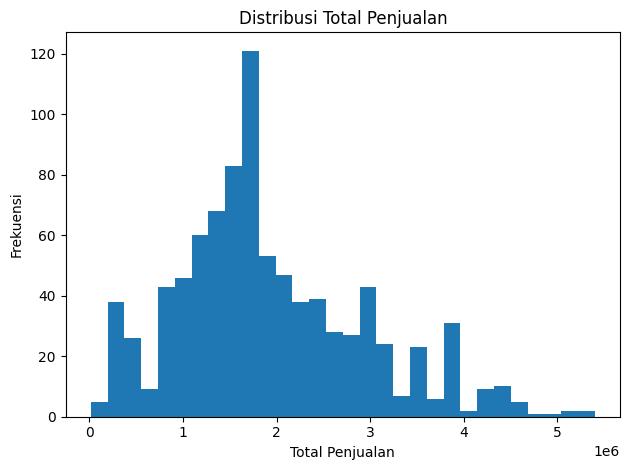

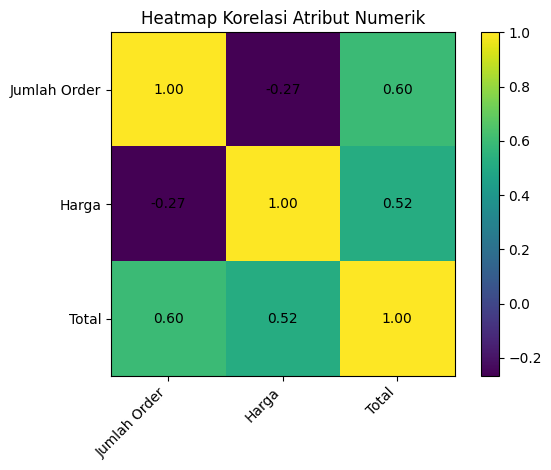

In [79]:
if "Total" in df.columns:
    plt.figure()
    plt.hist(df["Total"].dropna(), bins=30)
    plt.title("Distribusi Total Penjualan")
    plt.xlabel("Total Penjualan")
    plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.show()
else:
    print("\n[VISUALISASI] Kolom 'Total' tidak ditemukan, histogram dilewati.")

if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)
    fig, ax = plt.subplots()
    im = ax.imshow(corr.values)

    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.columns)

    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")

    plt.title("Heatmap Korelasi Atribut Numerik")
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()
else:
    print("\n[VISUALISASI] Atribut numerik kurang dari 2, heatmap dilewati.")

## Kesimpulan Analisis Data Penjualan

1. **Kualitas Data**
   - Data sudah dibersihkan: kolom `Tanggal` berhasil dikonversi ke tipe datetime, kolom kategori `Jenis Produk` sudah distandarisasi.
   - Tidak ada missing values setelah cleaning, namun terdapat beberapa duplikat yang perlu diperhatikan jika analisis lanjutan dilakukan.

2. **Karakteristik Dataset**
   - Jumlah record: **1076 baris** dengan **5 atribut**.
   - Atribut numerik: `Jumlah Order`, `Harga`, `Total`.
   - Atribut kategori: `Jenis Produk` (91 jenis produk unik).

3. **Statistik Deskriptif**
   - Rata-rata jumlah order: ±1904 (Q2 = 1000).
   - Rata-rata harga: ±1704 (Q2 = 1500).
   - Rata-rata total transaksi: ±2.345.827 (Q2 = 1.800.000).
   - Distribusi data menunjukkan adanya **outlier** dengan nilai total transaksi hingga lebih dari 21 juta.

4. **Hasil Visualisasi**
   - **Histogram Total Penjualan** menunjukkan distribusi right-skewed: transaksi kecil-menengah lebih dominan, sementara transaksi besar relatif jarang.
   - **Heatmap Korelasi** menunjukkan `Jumlah Order` memiliki korelasi paling kuat dengan `Total`, diikuti oleh `Harga`.

5. **Insight Utama**
   - Variasi jumlah order lebih memengaruhi total penjualan dibanding variasi harga.
   - Perusahaan sebaiknya memperhatikan outlier (transaksi sangat besar) karena dapat memengaruhi analisis lanjutan.
   - Potensi segmentasi produk bisa dilakukan dengan menganalisis 91 kategori `Jenis Produk`.

---
